### Team members

1. Amirhossein Soltani
2. Moein Taherkhani

In [1]:
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import torchvision.transforms as transforms
import torchvision.datasets as datasets


/home_domuser/s06mtahe/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Downloading the dataset


In [2]:

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor(), download=True)

100%|██████████| 170498071/170498071 [00:06<00:00, 26197113.70it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Dataset inspection

In [3]:
print(f"# Images Train: {len(train_dataset)}")
print(f"# Images Test:  {len(test_dataset)}")

# Images Train: 50000
# Images Test:  10000


In [4]:
img_shape = train_dataset[0][0].shape
label = train_dataset[0][1]

print(f"Image shape: {img_shape}")
print(f"Label: {label}")

Image shape: torch.Size([3, 32, 32])
Label: 6


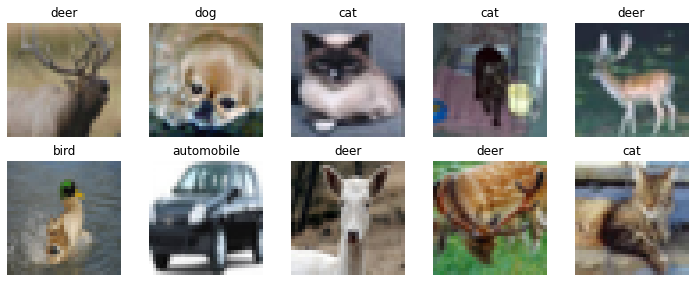

In [5]:
import matplotlib.pyplot as plt


classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
          "horse", "ship", "truck"]

N_IMGS = 8
fig, ax = plt.subplots(2,5)
fig.set_size_inches(10, 4)

ids = np.random.randint(low=0, high=len(train_dataset), size=N_IMGS)

for i in range(2):
    for j in range (5):
        id = np.random.randint(0,len(train_dataset),1)[0]
        img = train_dataset[id][0].numpy().transpose((1,2,0))
        ax[i,j].imshow(img)
        ax[i,j].set_title(f"{classes[train_dataset[id][1]]}")
        ax[i,j].axis("off")
plt.tight_layout()
plt.show()


### Dataloaders

In [6]:
training_config = {'BATCH_SIZE' : 512,
                   'lr' : 4e-5,
                   'epochs' : 100
                   }


train_loader =  torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=training_config['BATCH_SIZE'],
        shuffle=True
    )

eval_loader =  torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=training_config['BATCH_SIZE'],
        shuffle=False,
        drop_last=True
    )

## MLP

In [7]:
class Model(nn.Module):
    """
    MLP composed of two fully connected layers.
     - First layer takes pixel values and maps them to a hidden dimension
     - Nonlinear activation
     - Second layer maps from hidden dimension to number of classes, predicting a score for each of the classes
    """
    def __init__(self, input_dim=3072, hidden_dim=256, output_dim=len(classes)):
        """ Model initalizer """
        super().__init__()
        self.layers = nn.Sequential(
                nn.Linear(in_features=input_dim, out_features=hidden_dim),
                nn.ReLU(),
                nn.Linear(in_features=hidden_dim, out_features=output_dim)
            )
        
    def forward(self, x):
        """ Forward pass through the model"""
        assert len(x.shape) == 2, f"ERROR! Shape of input must be 2D (b_size, dim)"
        pred = self.layers(x)
        return pred


In [8]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mlp_model = Model().to(device)

summary(mlp_model, input_size=(3072,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         786,688
              ReLU-2                  [-1, 256]               0
            Linear-3                   [-1, 10]           2,570
Total params: 789,258
Trainable params: 789,258
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 3.01
Estimated Total Size (MB): 3.03
----------------------------------------------------------------


In [9]:
criterion = nn.CrossEntropyLoss()  # already includes a Softmax!
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=training_config['lr'])

In [64]:
log_dict = {'Training_loss' : [] ,'Validation_loss' : [] }

print("##### TRAINING ... ####")
mlp_model.train()
for epoch in range(training_config['epochs']):
    progress_bar = tqdm(train_loader, total=len(train_loader))
    for i, (imgs, labels) in enumerate(progress_bar):
        imgs, labels = imgs.to(device), labels.to(device)
    
        # forward pass
        flattened_imgs = imgs.flatten(start_dim=1)
        preds = mlp_model(flattened_imgs)

        loss = criterion(preds, labels)
        log_dict['Training_loss'].append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if(i % 10 == 0 or i == len(train_loader) - 1):
            progress_bar.set_description(f"Epoch {epoch + 1} Iter {i + 1}: loss {loss.item():.5f}. ")

        # Running evaluation every 5 epochs
        if epoch % 5 == 0:
            print("##### EVALUATION ... ####")
            mlp_model.eval()
            n_correct = 0

            with torch.no_grad():
                progress_bar = tqdm(enumerate(eval_loader), total=len(eval_loader))
                for i, (imgs, labels) in progress_bar: 
                    imgs, labels = imgs.to(device), labels.to(device)

                    flattened_imgs = imgs.flatten(start_dim=1)
                    preds = mlp_model(flattened_imgs)
                    
                    # Just to monitor validation loss
                    loss = criterion(preds, labels)
                    log_dict['Validation_loss'].append(loss.item())

                    pred_labels = torch.argmax(torch.softmax(preds, dim=-1), dim=-1)
                    cur_correct = len(torch.where(pred_labels == labels)[0])
                    n_correct = n_correct + cur_correct

            accuracy = n_correct / len(test_dataset) * 100
            print(f"Test accuracy: {round(accuracy,2)}%") 

##### TRAINING ... ####


Epoch 1 Iter 1: loss 2.31028. :   0%|          | 0/98 [00:00<?, ?it/s]

##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :   1%|          | 1/98 [00:01<02:42,  1.68s/it]

Test accuracy: 9.99%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :   2%|▏         | 2/98 [00:02<02:13,  1.39s/it]

Test accuracy: 13.14%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :   3%|▎         | 3/98 [00:04<02:05,  1.32s/it]

Test accuracy: 14.93%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :   4%|▍         | 4/98 [00:05<02:00,  1.28s/it]

Test accuracy: 12.84%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :   5%|▌         | 5/98 [00:06<01:54,  1.23s/it]

Test accuracy: 13.24%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :   6%|▌         | 6/98 [00:07<01:52,  1.22s/it]

Test accuracy: 13.08%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :   7%|▋         | 7/98 [00:08<01:48,  1.19s/it]

Test accuracy: 13.04%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :   8%|▊         | 8/98 [00:10<01:48,  1.21s/it]

Test accuracy: 13.72%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :   9%|▉         | 9/98 [00:11<01:48,  1.22s/it]

Test accuracy: 15.74%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  10%|█         | 10/98 [00:12<01:45,  1.20s/it]

Test accuracy: 17.62%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  11%|█         | 11/98 [00:13<01:46,  1.22s/it]

Test accuracy: 17.94%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  12%|█▏        | 12/98 [00:14<01:43,  1.20s/it]

Test accuracy: 18.38%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  13%|█▎        | 13/98 [00:16<01:43,  1.22s/it]

Test accuracy: 18.59%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  14%|█▍        | 14/98 [00:17<01:43,  1.24s/it]

Test accuracy: 18.7%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  15%|█▌        | 15/98 [00:18<01:39,  1.20s/it]

Test accuracy: 18.59%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  16%|█▋        | 16/98 [00:19<01:39,  1.21s/it]

Test accuracy: 18.72%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  17%|█▋        | 17/98 [00:20<01:38,  1.22s/it]

Test accuracy: 19.98%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  18%|█▊        | 18/98 [00:22<01:35,  1.20s/it]

Test accuracy: 21.23%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  19%|█▉        | 19/98 [00:23<01:35,  1.21s/it]

Test accuracy: 21.91%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  20%|██        | 20/98 [00:24<01:34,  1.22s/it]

Test accuracy: 23.2%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  21%|██▏       | 21/98 [00:25<01:32,  1.20s/it]

Test accuracy: 23.99%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  22%|██▏       | 22/98 [00:26<01:31,  1.21s/it]

Test accuracy: 24.35%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  23%|██▎       | 23/98 [00:28<01:29,  1.19s/it]

Test accuracy: 24.54%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  24%|██▍       | 24/98 [00:29<01:30,  1.22s/it]

Test accuracy: 24.91%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  26%|██▌       | 25/98 [00:30<01:29,  1.23s/it]

Test accuracy: 24.88%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  27%|██▋       | 26/98 [00:31<01:28,  1.24s/it]

Test accuracy: 25.32%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  28%|██▊       | 27/98 [00:33<01:30,  1.27s/it]

Test accuracy: 26.13%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  29%|██▊       | 28/98 [00:34<01:27,  1.25s/it]

Test accuracy: 26.4%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  30%|██▉       | 29/98 [00:35<01:27,  1.27s/it]

Test accuracy: 25.98%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  31%|███       | 30/98 [00:37<01:25,  1.26s/it]

Test accuracy: 25.55%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  32%|███▏      | 31/98 [00:38<01:25,  1.28s/it]

Test accuracy: 25.69%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  33%|███▎      | 32/98 [00:39<01:24,  1.28s/it]

Test accuracy: 25.53%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  34%|███▎      | 33/98 [00:40<01:22,  1.28s/it]

Test accuracy: 25.08%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  35%|███▍      | 34/98 [00:42<01:23,  1.30s/it]

Test accuracy: 24.65%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  36%|███▌      | 35/98 [00:43<01:21,  1.29s/it]

Test accuracy: 24.06%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  37%|███▋      | 36/98 [00:44<01:21,  1.31s/it]

Test accuracy: 24.07%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  38%|███▊      | 37/98 [00:46<01:19,  1.30s/it]

Test accuracy: 24.6%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  39%|███▉      | 38/98 [00:47<01:18,  1.31s/it]

Test accuracy: 25.06%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  40%|███▉      | 39/98 [00:48<01:16,  1.30s/it]

Test accuracy: 25.41%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  41%|████      | 40/98 [00:50<01:16,  1.32s/it]

Test accuracy: 25.58%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  42%|████▏     | 41/98 [00:51<01:16,  1.34s/it]

Test accuracy: 25.25%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  43%|████▎     | 42/98 [00:52<01:13,  1.32s/it]

Test accuracy: 24.81%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  44%|████▍     | 43/98 [00:54<01:13,  1.33s/it]

Test accuracy: 24.58%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  45%|████▍     | 44/98 [00:55<01:11,  1.32s/it]

Test accuracy: 23.75%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  46%|████▌     | 45/98 [00:56<01:11,  1.35s/it]

Test accuracy: 23.13%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  47%|████▋     | 46/98 [00:58<01:10,  1.35s/it]

Test accuracy: 22.89%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  48%|████▊     | 47/98 [00:59<01:08,  1.35s/it]

Test accuracy: 23.16%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  49%|████▉     | 48/98 [01:00<01:08,  1.36s/it]

Test accuracy: 23.77%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  50%|█████     | 49/98 [01:02<01:06,  1.36s/it]

Test accuracy: 24.73%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  51%|█████     | 50/98 [01:03<01:05,  1.36s/it]

Test accuracy: 25.94%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  52%|█████▏    | 51/98 [01:05<01:03,  1.35s/it]

Test accuracy: 26.72%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  53%|█████▎    | 52/98 [01:06<01:02,  1.36s/it]

Test accuracy: 27.19%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  54%|█████▍    | 53/98 [01:07<01:01,  1.37s/it]

Test accuracy: 27.24%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  55%|█████▌    | 54/98 [01:09<00:59,  1.36s/it]

Test accuracy: 27.5%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  56%|█████▌    | 55/98 [01:10<00:59,  1.38s/it]

Test accuracy: 27.44%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  57%|█████▋    | 56/98 [01:11<00:57,  1.37s/it]

Test accuracy: 27.16%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  58%|█████▊    | 57/98 [01:13<00:56,  1.38s/it]

Test accuracy: 27.73%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  59%|█████▉    | 58/98 [01:14<00:54,  1.37s/it]

Test accuracy: 27.73%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  60%|██████    | 59/98 [01:16<00:54,  1.39s/it]

Test accuracy: 27.45%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  61%|██████    | 60/98 [01:17<00:53,  1.40s/it]

Test accuracy: 27.51%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  62%|██████▏   | 61/98 [01:18<00:51,  1.38s/it]

Test accuracy: 27.09%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  63%|██████▎   | 62/98 [01:20<00:49,  1.39s/it]

Test accuracy: 26.35%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  64%|██████▍   | 63/98 [01:21<00:48,  1.37s/it]

Test accuracy: 26.01%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  65%|██████▌   | 64/98 [01:22<00:46,  1.38s/it]

Test accuracy: 26.47%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  66%|██████▋   | 65/98 [01:24<00:46,  1.40s/it]

Test accuracy: 26.98%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  67%|██████▋   | 66/98 [01:25<00:44,  1.38s/it]

Test accuracy: 27.26%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  68%|██████▊   | 67/98 [01:27<00:43,  1.39s/it]

Test accuracy: 27.59%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  69%|██████▉   | 68/98 [01:28<00:41,  1.38s/it]

Test accuracy: 27.59%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  70%|███████   | 69/98 [01:29<00:40,  1.39s/it]

Test accuracy: 27.82%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  71%|███████▏  | 70/98 [01:31<00:39,  1.40s/it]

Test accuracy: 28.02%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  72%|███████▏  | 71/98 [01:32<00:37,  1.38s/it]

Test accuracy: 28.1%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  73%|███████▎  | 72/98 [01:34<00:36,  1.39s/it]

Test accuracy: 28.09%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  74%|███████▍  | 73/98 [01:35<00:35,  1.41s/it]

Test accuracy: 28.34%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  76%|███████▌  | 74/98 [01:37<00:34,  1.43s/it]

Test accuracy: 28.73%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  77%|███████▋  | 75/98 [01:38<00:32,  1.42s/it]

Test accuracy: 29.09%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  78%|███████▊  | 76/98 [01:39<00:31,  1.44s/it]

Test accuracy: 29.43%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  79%|███████▊  | 77/98 [01:41<00:30,  1.44s/it]

Test accuracy: 29.65%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  80%|███████▉  | 78/98 [01:42<00:28,  1.42s/it]

Test accuracy: 29.99%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  81%|████████  | 79/98 [01:44<00:27,  1.44s/it]

Test accuracy: 29.94%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  82%|████████▏ | 80/98 [01:45<00:25,  1.42s/it]

Test accuracy: 29.53%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  83%|████████▎ | 81/98 [01:47<00:24,  1.42s/it]

Test accuracy: 29.09%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  84%|████████▎ | 82/98 [01:48<00:22,  1.42s/it]

Test accuracy: 28.91%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  85%|████████▍ | 83/98 [01:49<00:20,  1.39s/it]

Test accuracy: 28.86%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  86%|████████▌ | 84/98 [01:51<00:19,  1.40s/it]

Test accuracy: 28.79%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  87%|████████▋ | 85/98 [01:52<00:17,  1.38s/it]

Test accuracy: 28.81%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  88%|████████▊ | 86/98 [01:53<00:16,  1.39s/it]

Test accuracy: 28.8%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  89%|████████▉ | 87/98 [01:55<00:14,  1.36s/it]

Test accuracy: 28.88%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  90%|████████▉ | 88/98 [01:56<00:13,  1.36s/it]

Test accuracy: 28.9%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  91%|█████████ | 89/98 [01:57<00:12,  1.36s/it]

Test accuracy: 29.03%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  92%|█████████▏| 90/98 [01:59<00:10,  1.35s/it]

Test accuracy: 28.89%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  93%|█████████▎| 91/98 [02:00<00:09,  1.36s/it]

Test accuracy: 28.83%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  94%|█████████▍| 92/98 [02:01<00:08,  1.35s/it]

Test accuracy: 29.07%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  95%|█████████▍| 93/98 [02:03<00:06,  1.36s/it]

Test accuracy: 29.05%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  96%|█████████▌| 94/98 [02:04<00:05,  1.37s/it]

Test accuracy: 29.06%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  97%|█████████▋| 95/98 [02:06<00:04,  1.35s/it]

Test accuracy: 29.06%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  98%|█████████▊| 96/98 [02:07<00:02,  1.36s/it]

Test accuracy: 29.46%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. :  99%|█████████▉| 97/98 [02:08<00:01,  1.36s/it]

Test accuracy: 30.31%
##### EVALUATION ... ####


Epoch 1 Iter 1: loss 2.31028. : 100%|██████████| 98/98 [02:10<00:00,  1.33s/it]


Test accuracy: 30.59%


Epoch 6 Iter 1: loss 1.85328. :   0%|          | 0/98 [00:00<?, ?it/s]

##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :   1%|          | 1/98 [00:01<02:13,  1.37s/it]

Test accuracy: 35.98%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :   2%|▏         | 2/98 [00:02<02:09,  1.35s/it]

Test accuracy: 36.11%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :   3%|▎         | 3/98 [00:04<02:08,  1.35s/it]

Test accuracy: 36.16%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :   4%|▍         | 4/98 [00:05<02:08,  1.36s/it]

Test accuracy: 35.99%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :   5%|▌         | 5/98 [00:06<02:05,  1.35s/it]

Test accuracy: 36.11%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :   6%|▌         | 6/98 [00:08<02:08,  1.40s/it]

Test accuracy: 36.39%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :   7%|▋         | 7/98 [00:09<02:06,  1.39s/it]

Test accuracy: 36.6%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :   8%|▊         | 8/98 [00:10<02:04,  1.38s/it]

Test accuracy: 36.86%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :   9%|▉         | 9/98 [00:12<02:01,  1.37s/it]

Test accuracy: 36.87%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  10%|█         | 10/98 [00:13<02:01,  1.38s/it]

Test accuracy: 36.49%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  11%|█         | 11/98 [00:15<02:01,  1.39s/it]

Test accuracy: 36.22%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  12%|█▏        | 12/98 [00:16<01:58,  1.38s/it]

Test accuracy: 36.15%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  13%|█▎        | 13/98 [00:17<01:57,  1.38s/it]

Test accuracy: 36.17%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  14%|█▍        | 14/98 [00:19<01:55,  1.37s/it]

Test accuracy: 36.27%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  15%|█▌        | 15/98 [00:20<01:54,  1.38s/it]

Test accuracy: 36.42%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  16%|█▋        | 16/98 [00:21<01:51,  1.36s/it]

Test accuracy: 36.52%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  17%|█▋        | 17/98 [00:23<01:50,  1.36s/it]

Test accuracy: 36.64%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  18%|█▊        | 18/98 [00:24<01:50,  1.38s/it]

Test accuracy: 36.72%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  19%|█▉        | 19/98 [00:26<01:47,  1.36s/it]

Test accuracy: 36.58%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  20%|██        | 20/98 [00:27<01:46,  1.36s/it]

Test accuracy: 36.5%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  21%|██▏       | 21/98 [00:28<01:43,  1.35s/it]

Test accuracy: 36.47%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  22%|██▏       | 22/98 [00:30<01:43,  1.36s/it]

Test accuracy: 36.58%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  23%|██▎       | 23/98 [00:31<01:41,  1.35s/it]

Test accuracy: 36.71%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  24%|██▍       | 24/98 [00:32<01:41,  1.37s/it]

Test accuracy: 36.48%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  26%|██▌       | 25/98 [00:34<01:39,  1.37s/it]

Test accuracy: 36.31%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  27%|██▋       | 26/98 [00:35<01:37,  1.35s/it]

Test accuracy: 36.09%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  28%|██▊       | 27/98 [00:36<01:36,  1.36s/it]

Test accuracy: 36.19%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  29%|██▊       | 28/98 [00:38<01:34,  1.35s/it]

Test accuracy: 36.4%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  30%|██▉       | 29/98 [00:39<01:34,  1.37s/it]

Test accuracy: 36.68%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  31%|███       | 30/98 [00:41<01:34,  1.38s/it]

Test accuracy: 36.93%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  32%|███▏      | 31/98 [00:42<01:30,  1.36s/it]

Test accuracy: 36.68%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  33%|███▎      | 32/98 [00:43<01:29,  1.36s/it]

Test accuracy: 36.43%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  34%|███▎      | 33/98 [00:45<01:27,  1.35s/it]

Test accuracy: 36.29%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  35%|███▍      | 34/98 [00:46<01:27,  1.36s/it]

Test accuracy: 36.21%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  36%|███▌      | 35/98 [00:47<01:25,  1.35s/it]

Test accuracy: 36.21%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  37%|███▋      | 36/98 [00:49<01:24,  1.36s/it]

Test accuracy: 36.04%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  38%|███▊      | 37/98 [00:50<01:23,  1.36s/it]

Test accuracy: 35.95%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  39%|███▉      | 38/98 [00:51<01:21,  1.35s/it]

Test accuracy: 35.96%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  40%|███▉      | 39/98 [00:53<01:21,  1.37s/it]

Test accuracy: 35.97%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  41%|████      | 40/98 [00:54<01:18,  1.36s/it]

Test accuracy: 36.07%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  42%|████▏     | 41/98 [00:55<01:17,  1.37s/it]

Test accuracy: 36.21%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  43%|████▎     | 42/98 [00:57<01:17,  1.38s/it]

Test accuracy: 36.55%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  44%|████▍     | 43/98 [00:58<01:14,  1.36s/it]

Test accuracy: 36.46%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  45%|████▍     | 44/98 [01:00<01:14,  1.37s/it]

Test accuracy: 36.58%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  46%|████▌     | 45/98 [01:01<01:12,  1.36s/it]

Test accuracy: 36.69%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  47%|████▋     | 46/98 [01:02<01:11,  1.37s/it]

Test accuracy: 36.78%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  48%|████▊     | 47/98 [01:04<01:12,  1.42s/it]

Test accuracy: 36.91%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  49%|████▉     | 48/98 [01:05<01:10,  1.41s/it]

Test accuracy: 37.04%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  50%|█████     | 49/98 [01:07<01:10,  1.43s/it]

Test accuracy: 37.17%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  51%|█████     | 50/98 [01:08<01:07,  1.41s/it]

Test accuracy: 37.24%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  52%|█████▏    | 51/98 [01:09<01:05,  1.40s/it]

Test accuracy: 37.22%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  53%|█████▎    | 52/98 [01:11<01:04,  1.41s/it]

Test accuracy: 36.95%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  54%|█████▍    | 53/98 [01:12<01:02,  1.39s/it]

Test accuracy: 36.78%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  55%|█████▌    | 54/98 [01:14<01:01,  1.39s/it]

Test accuracy: 36.64%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  56%|█████▌    | 55/98 [01:15<00:59,  1.38s/it]

Test accuracy: 36.54%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  57%|█████▋    | 56/98 [01:16<00:58,  1.38s/it]

Test accuracy: 36.47%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  58%|█████▊    | 57/98 [01:18<00:57,  1.40s/it]

Test accuracy: 36.46%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  59%|█████▉    | 58/98 [01:19<00:55,  1.39s/it]

Test accuracy: 36.56%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  60%|██████    | 59/98 [01:21<00:54,  1.40s/it]

Test accuracy: 36.85%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  61%|██████    | 60/98 [01:22<00:52,  1.39s/it]

Test accuracy: 36.96%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  62%|██████▏   | 61/98 [01:23<00:51,  1.39s/it]

Test accuracy: 37.03%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  63%|██████▎   | 62/98 [01:25<00:50,  1.40s/it]

Test accuracy: 37.2%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  64%|██████▍   | 63/98 [01:26<00:48,  1.38s/it]

Test accuracy: 37.31%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  65%|██████▌   | 64/98 [01:28<00:47,  1.40s/it]

Test accuracy: 37.22%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  66%|██████▋   | 65/98 [01:29<00:45,  1.38s/it]

Test accuracy: 37.21%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  67%|██████▋   | 66/98 [01:30<00:44,  1.39s/it]

Test accuracy: 37.31%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  68%|██████▊   | 67/98 [01:32<00:43,  1.41s/it]

Test accuracy: 36.95%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  69%|██████▉   | 68/98 [01:33<00:41,  1.38s/it]

Test accuracy: 36.62%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  70%|███████   | 69/98 [01:34<00:40,  1.38s/it]

Test accuracy: 36.58%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  71%|███████▏  | 70/98 [01:36<00:38,  1.37s/it]

Test accuracy: 36.61%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  72%|███████▏  | 71/98 [01:37<00:37,  1.38s/it]

Test accuracy: 36.63%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  73%|███████▎  | 72/98 [01:39<00:36,  1.39s/it]

Test accuracy: 36.81%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  74%|███████▍  | 73/98 [01:40<00:34,  1.37s/it]

Test accuracy: 37.22%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  76%|███████▌  | 74/98 [01:41<00:33,  1.38s/it]

Test accuracy: 37.26%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  77%|███████▋  | 75/98 [01:43<00:31,  1.37s/it]

Test accuracy: 37.17%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  78%|███████▊  | 76/98 [01:44<00:30,  1.38s/it]

Test accuracy: 37.09%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  79%|███████▊  | 77/98 [01:46<00:29,  1.39s/it]

Test accuracy: 37.1%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  80%|███████▉  | 78/98 [01:47<00:27,  1.37s/it]

Test accuracy: 37.2%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  81%|████████  | 79/98 [01:48<00:26,  1.38s/it]

Test accuracy: 37.13%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  82%|████████▏ | 80/98 [01:50<00:24,  1.36s/it]

Test accuracy: 37.06%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  83%|████████▎ | 81/98 [01:51<00:23,  1.37s/it]

Test accuracy: 36.95%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  84%|████████▎ | 82/98 [01:52<00:22,  1.38s/it]

Test accuracy: 37.01%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  85%|████████▍ | 83/98 [01:54<00:20,  1.37s/it]

Test accuracy: 37.12%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  86%|████████▌ | 84/98 [01:55<00:19,  1.38s/it]

Test accuracy: 37.17%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  87%|████████▋ | 85/98 [01:56<00:17,  1.38s/it]

Test accuracy: 37.13%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  88%|████████▊ | 86/98 [01:58<00:16,  1.41s/it]

Test accuracy: 37.41%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  89%|████████▉ | 87/98 [01:59<00:15,  1.41s/it]

Test accuracy: 37.25%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  90%|████████▉ | 88/98 [02:01<00:13,  1.39s/it]

Test accuracy: 37.2%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  91%|█████████ | 89/98 [02:02<00:12,  1.39s/it]

Test accuracy: 37.12%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  92%|█████████▏| 90/98 [02:04<00:11,  1.40s/it]

Test accuracy: 37.14%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  93%|█████████▎| 91/98 [02:05<00:09,  1.38s/it]

Test accuracy: 37.14%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  94%|█████████▍| 92/98 [02:06<00:08,  1.39s/it]

Test accuracy: 37.23%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  95%|█████████▍| 93/98 [02:08<00:06,  1.38s/it]

Test accuracy: 37.19%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  96%|█████████▌| 94/98 [02:09<00:05,  1.39s/it]

Test accuracy: 37.35%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  97%|█████████▋| 95/98 [02:10<00:04,  1.40s/it]

Test accuracy: 37.18%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  98%|█████████▊| 96/98 [02:12<00:02,  1.38s/it]

Test accuracy: 37.13%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. :  99%|█████████▉| 97/98 [02:13<00:01,  1.38s/it]

Test accuracy: 37.13%
##### EVALUATION ... ####


Epoch 6 Iter 1: loss 1.85328. : 100%|██████████| 98/98 [02:15<00:00,  1.38s/it]


Test accuracy: 36.83%


Epoch 11 Iter 1: loss 1.66646. :   0%|          | 0/98 [00:00<?, ?it/s]

##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :   1%|          | 1/98 [00:01<02:11,  1.36s/it]

Test accuracy: 38.9%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :   2%|▏         | 2/98 [00:02<02:06,  1.31s/it]

Test accuracy: 38.89%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :   3%|▎         | 3/98 [00:04<02:07,  1.34s/it]

Test accuracy: 38.89%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :   4%|▍         | 4/98 [00:05<02:06,  1.35s/it]

Test accuracy: 39.1%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :   5%|▌         | 5/98 [00:06<02:08,  1.39s/it]

Test accuracy: 39.27%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :   6%|▌         | 6/98 [00:08<02:12,  1.44s/it]

Test accuracy: 39.21%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :   7%|▋         | 7/98 [00:09<02:08,  1.41s/it]

Test accuracy: 39.01%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :   8%|▊         | 8/98 [00:11<02:06,  1.40s/it]

Test accuracy: 39.17%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :   9%|▉         | 9/98 [00:12<02:02,  1.38s/it]

Test accuracy: 39.12%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  10%|█         | 10/98 [00:13<01:56,  1.32s/it]

Test accuracy: 39.1%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  11%|█         | 11/98 [00:14<01:55,  1.32s/it]

Test accuracy: 38.77%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  12%|█▏        | 12/98 [00:16<01:52,  1.31s/it]

Test accuracy: 38.63%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  13%|█▎        | 13/98 [00:17<01:53,  1.34s/it]

Test accuracy: 38.54%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  14%|█▍        | 14/98 [00:19<01:53,  1.35s/it]

Test accuracy: 38.39%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  15%|█▌        | 15/98 [00:20<01:50,  1.33s/it]

Test accuracy: 38.55%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  16%|█▋        | 16/98 [00:21<01:50,  1.34s/it]

Test accuracy: 38.68%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  17%|█▋        | 17/98 [00:22<01:47,  1.33s/it]

Test accuracy: 38.78%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  18%|█▊        | 18/98 [00:24<01:46,  1.33s/it]

Test accuracy: 39.19%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  19%|█▉        | 19/98 [00:25<01:44,  1.32s/it]

Test accuracy: 39.44%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  20%|██        | 20/98 [00:26<01:41,  1.30s/it]

Test accuracy: 39.29%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  21%|██▏       | 21/98 [00:28<01:42,  1.33s/it]

Test accuracy: 39.18%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  22%|██▏       | 22/98 [00:29<01:40,  1.32s/it]

Test accuracy: 38.99%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  23%|██▎       | 23/98 [00:30<01:40,  1.34s/it]

Test accuracy: 39.02%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  24%|██▍       | 24/98 [00:32<01:38,  1.33s/it]

Test accuracy: 39.29%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  26%|██▌       | 25/98 [00:33<01:35,  1.31s/it]

Test accuracy: 39.18%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  27%|██▋       | 26/98 [00:34<01:35,  1.33s/it]

Test accuracy: 39.16%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  28%|██▊       | 27/98 [00:36<01:32,  1.30s/it]

Test accuracy: 39.0%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  29%|██▊       | 28/98 [00:37<01:32,  1.32s/it]

Test accuracy: 38.95%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  30%|██▉       | 29/98 [00:38<01:33,  1.36s/it]

Test accuracy: 38.85%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  31%|███       | 30/98 [00:40<01:31,  1.35s/it]

Test accuracy: 38.73%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  32%|███▏      | 31/98 [00:41<01:30,  1.36s/it]

Test accuracy: 38.79%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  33%|███▎      | 32/98 [00:42<01:29,  1.35s/it]

Test accuracy: 38.68%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  34%|███▎      | 33/98 [00:44<01:29,  1.38s/it]

Test accuracy: 38.73%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  35%|███▍      | 34/98 [00:45<01:26,  1.36s/it]

Test accuracy: 38.83%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  36%|███▌      | 35/98 [00:47<01:25,  1.36s/it]

Test accuracy: 38.84%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  37%|███▋      | 36/98 [00:48<01:25,  1.37s/it]

Test accuracy: 38.98%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  38%|███▊      | 37/98 [00:49<01:23,  1.36s/it]

Test accuracy: 39.19%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  39%|███▉      | 38/98 [00:51<01:22,  1.37s/it]

Test accuracy: 39.2%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  40%|███▉      | 39/98 [00:52<01:20,  1.36s/it]

Test accuracy: 39.41%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  41%|████      | 40/98 [00:53<01:20,  1.38s/it]

Test accuracy: 39.47%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  42%|████▏     | 41/98 [00:55<01:18,  1.39s/it]

Test accuracy: 39.35%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  43%|████▎     | 42/98 [00:56<01:17,  1.38s/it]

Test accuracy: 39.37%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  44%|████▍     | 43/98 [00:58<01:17,  1.41s/it]

Test accuracy: 39.48%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  45%|████▍     | 44/98 [00:59<01:16,  1.41s/it]

Test accuracy: 39.53%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  46%|████▌     | 45/98 [01:00<01:13,  1.40s/it]

Test accuracy: 39.47%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  47%|████▋     | 46/98 [01:02<01:12,  1.40s/it]

Test accuracy: 39.41%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  48%|████▊     | 47/98 [01:03<01:10,  1.38s/it]

Test accuracy: 39.55%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  49%|████▉     | 48/98 [01:05<01:09,  1.39s/it]

Test accuracy: 39.55%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  50%|█████     | 49/98 [01:06<01:07,  1.38s/it]

Test accuracy: 39.65%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  51%|█████     | 50/98 [01:07<01:06,  1.38s/it]

Test accuracy: 39.6%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  52%|█████▏    | 51/98 [01:09<01:05,  1.39s/it]

Test accuracy: 39.54%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  53%|█████▎    | 52/98 [01:10<01:04,  1.41s/it]

Test accuracy: 39.63%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  54%|█████▍    | 53/98 [01:12<01:01,  1.37s/it]

Test accuracy: 39.6%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  55%|█████▌    | 54/98 [01:13<00:58,  1.33s/it]

Test accuracy: 39.6%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  56%|█████▌    | 55/98 [01:14<00:56,  1.32s/it]

Test accuracy: 39.45%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  57%|█████▋    | 56/98 [01:15<00:55,  1.32s/it]

Test accuracy: 39.23%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  58%|█████▊    | 57/98 [01:17<00:53,  1.30s/it]

Test accuracy: 39.36%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  59%|█████▉    | 58/98 [01:18<00:51,  1.30s/it]

Test accuracy: 39.48%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  60%|██████    | 59/98 [01:19<00:49,  1.28s/it]

Test accuracy: 39.25%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  61%|██████    | 60/98 [01:21<00:49,  1.29s/it]

Test accuracy: 39.29%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  62%|██████▏   | 61/98 [01:22<00:47,  1.29s/it]

Test accuracy: 39.33%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  63%|██████▎   | 62/98 [01:23<00:46,  1.29s/it]

Test accuracy: 39.43%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  64%|██████▍   | 63/98 [01:25<00:46,  1.33s/it]

Test accuracy: 39.57%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  65%|██████▌   | 64/98 [01:26<00:44,  1.30s/it]

Test accuracy: 39.69%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  66%|██████▋   | 65/98 [01:27<00:43,  1.30s/it]

Test accuracy: 39.68%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  67%|██████▋   | 66/98 [01:28<00:40,  1.28s/it]

Test accuracy: 39.62%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  68%|██████▊   | 67/98 [01:30<00:39,  1.29s/it]

Test accuracy: 39.54%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  69%|██████▉   | 68/98 [01:31<00:37,  1.27s/it]

Test accuracy: 39.34%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  70%|███████   | 69/98 [01:32<00:37,  1.28s/it]

Test accuracy: 39.33%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  71%|███████▏  | 70/98 [01:33<00:36,  1.30s/it]

Test accuracy: 39.1%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  72%|███████▏  | 71/98 [01:35<00:34,  1.27s/it]

Test accuracy: 39.08%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  73%|███████▎  | 72/98 [01:36<00:33,  1.29s/it]

Test accuracy: 39.34%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  74%|███████▍  | 73/98 [01:37<00:31,  1.25s/it]

Test accuracy: 39.27%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  76%|███████▌  | 74/98 [01:38<00:30,  1.26s/it]

Test accuracy: 39.52%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  77%|███████▋  | 75/98 [01:40<00:29,  1.27s/it]

Test accuracy: 39.66%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  78%|███████▊  | 76/98 [01:41<00:27,  1.25s/it]

Test accuracy: 39.5%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  79%|███████▊  | 77/98 [01:42<00:26,  1.26s/it]

Test accuracy: 39.68%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  80%|███████▉  | 78/98 [01:43<00:25,  1.25s/it]

Test accuracy: 39.61%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  81%|████████  | 79/98 [01:45<00:24,  1.27s/it]

Test accuracy: 39.68%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  82%|████████▏ | 80/98 [01:46<00:22,  1.25s/it]

Test accuracy: 39.61%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  83%|████████▎ | 81/98 [01:47<00:21,  1.27s/it]

Test accuracy: 39.58%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  84%|████████▎ | 82/98 [01:49<00:20,  1.29s/it]

Test accuracy: 39.6%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  85%|████████▍ | 83/98 [01:50<00:19,  1.27s/it]

Test accuracy: 39.66%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  86%|████████▌ | 84/98 [01:51<00:18,  1.29s/it]

Test accuracy: 39.59%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  87%|████████▋ | 85/98 [01:52<00:16,  1.27s/it]

Test accuracy: 39.63%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  88%|████████▊ | 86/98 [01:54<00:15,  1.28s/it]

Test accuracy: 39.56%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  89%|████████▉ | 87/98 [01:55<00:14,  1.30s/it]

Test accuracy: 39.53%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  90%|████████▉ | 88/98 [01:56<00:12,  1.29s/it]

Test accuracy: 39.55%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  91%|█████████ | 89/98 [01:58<00:11,  1.30s/it]

Test accuracy: 39.51%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  92%|█████████▏| 90/98 [01:59<00:10,  1.28s/it]

Test accuracy: 39.44%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  93%|█████████▎| 91/98 [02:00<00:09,  1.29s/it]

Test accuracy: 39.44%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  94%|█████████▍| 92/98 [02:02<00:07,  1.30s/it]

Test accuracy: 39.41%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  95%|█████████▍| 93/98 [02:03<00:06,  1.28s/it]

Test accuracy: 39.48%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  96%|█████████▌| 94/98 [02:04<00:05,  1.28s/it]

Test accuracy: 39.5%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  97%|█████████▋| 95/98 [02:05<00:03,  1.27s/it]

Test accuracy: 39.35%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  98%|█████████▊| 96/98 [02:07<00:02,  1.27s/it]

Test accuracy: 39.43%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. :  99%|█████████▉| 97/98 [02:08<00:01,  1.25s/it]

Test accuracy: 39.29%
##### EVALUATION ... ####


Epoch 11 Iter 1: loss 1.66646. : 100%|██████████| 98/98 [02:09<00:00,  1.32s/it]


Test accuracy: 39.18%


Epoch 16 Iter 1: loss 1.60896. :   0%|          | 0/98 [00:00<?, ?it/s]

##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :   1%|          | 1/98 [00:01<02:10,  1.35s/it]

Test accuracy: 41.05%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :   2%|▏         | 2/98 [00:02<02:06,  1.32s/it]

Test accuracy: 41.05%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :   3%|▎         | 3/98 [00:04<02:08,  1.35s/it]

Test accuracy: 41.03%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :   4%|▍         | 4/98 [00:05<02:05,  1.34s/it]

Test accuracy: 41.33%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :   5%|▌         | 5/98 [00:06<02:05,  1.35s/it]

Test accuracy: 41.42%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :   6%|▌         | 6/98 [00:08<02:05,  1.37s/it]

Test accuracy: 41.43%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :   7%|▋         | 7/98 [00:09<02:02,  1.35s/it]

Test accuracy: 41.34%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :   8%|▊         | 8/98 [00:10<02:01,  1.35s/it]

Test accuracy: 41.17%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :   9%|▉         | 9/98 [00:12<01:58,  1.34s/it]

Test accuracy: 41.09%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :  10%|█         | 10/98 [00:13<01:58,  1.34s/it]

Test accuracy: 41.01%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :  11%|█         | 11/98 [00:14<01:55,  1.33s/it]

Test accuracy: 41.15%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :  12%|█▏        | 12/98 [00:16<01:55,  1.34s/it]

Test accuracy: 41.04%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :  13%|█▎        | 13/98 [00:17<01:55,  1.35s/it]

Test accuracy: 40.87%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :  14%|█▍        | 14/98 [00:18<01:52,  1.34s/it]

Test accuracy: 40.83%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :  15%|█▌        | 15/98 [00:20<01:51,  1.34s/it]

Test accuracy: 40.73%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :  16%|█▋        | 16/98 [00:21<01:49,  1.33s/it]

Test accuracy: 40.79%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :  17%|█▋        | 17/98 [00:22<01:47,  1.33s/it]

Test accuracy: 40.88%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :  18%|█▊        | 18/98 [00:24<01:47,  1.34s/it]

Test accuracy: 40.91%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :  19%|█▉        | 19/98 [00:25<01:44,  1.33s/it]

Test accuracy: 41.05%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :  20%|██        | 20/98 [00:26<01:44,  1.33s/it]

Test accuracy: 41.25%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :  21%|██▏       | 21/98 [00:28<01:41,  1.32s/it]

Test accuracy: 41.29%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :  22%|██▏       | 22/98 [00:29<01:40,  1.32s/it]

Test accuracy: 41.38%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :  23%|██▎       | 23/98 [00:30<01:38,  1.31s/it]

Test accuracy: 41.26%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :  24%|██▍       | 24/98 [00:32<01:38,  1.33s/it]

Test accuracy: 41.15%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :  26%|██▌       | 25/98 [00:33<01:38,  1.35s/it]

Test accuracy: 41.02%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :  27%|██▋       | 26/98 [00:34<01:35,  1.33s/it]

Test accuracy: 40.99%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :  28%|██▊       | 27/98 [00:36<01:34,  1.33s/it]

Test accuracy: 41.05%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :  29%|██▊       | 28/98 [00:37<01:32,  1.32s/it]

Test accuracy: 41.02%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :  30%|██▉       | 29/98 [00:38<01:30,  1.32s/it]

Test accuracy: 40.97%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :  31%|███       | 30/98 [00:40<01:30,  1.33s/it]

Test accuracy: 40.91%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :  32%|███▏      | 31/98 [00:41<01:28,  1.31s/it]

Test accuracy: 41.03%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :  33%|███▎      | 32/98 [00:42<01:27,  1.32s/it]

Test accuracy: 41.1%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :  34%|███▎      | 33/98 [00:43<01:25,  1.31s/it]

Test accuracy: 41.09%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :  35%|███▍      | 34/98 [00:45<01:24,  1.32s/it]

Test accuracy: 41.17%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :  36%|███▌      | 35/98 [00:46<01:22,  1.32s/it]

Test accuracy: 41.28%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :  37%|███▋      | 36/98 [00:47<01:21,  1.32s/it]

Test accuracy: 41.35%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :  38%|███▊      | 37/98 [00:49<01:21,  1.33s/it]

Test accuracy: 41.12%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :  39%|███▉      | 38/98 [00:50<01:19,  1.32s/it]

Test accuracy: 41.37%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :  40%|███▉      | 39/98 [00:51<01:18,  1.32s/it]

Test accuracy: 41.44%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :  41%|████      | 40/98 [00:53<01:16,  1.31s/it]

Test accuracy: 41.45%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :  42%|████▏     | 41/98 [00:54<01:15,  1.33s/it]

Test accuracy: 41.48%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :  43%|████▎     | 42/98 [00:55<01:14,  1.32s/it]

Test accuracy: 41.51%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :  44%|████▍     | 43/98 [00:57<01:13,  1.33s/it]

Test accuracy: 41.34%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :  45%|████▍     | 44/98 [00:58<01:12,  1.35s/it]

Test accuracy: 41.56%
##### EVALUATION ... ####


Epoch 16 Iter 1: loss 1.60896. :  46%|████▌     | 45/98 [00:59<01:10,  1.33s/it]

Test accuracy: 41.38%
##### EVALUATION ... ####
